## 관심 영역으로 자르기
- simple lane detection with OpenCV 따라하기
- 사진출처 : https://ichi.pro/ko/1-jang-jayul-juhaeng-jadongcha-dolo-eseo-chaseon-chajgi-udacity-peulojegteu-python-tutoriel-82556111232263
- 코드출처: https://medium.com/@mrhwick/simple-lane-detection-with-opencv-bfeb6ae54ec0

#### 메모리에 이미지 로드

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import math
%matplotlib inline

This image is:  <class 'numpy.ndarray'> with dimensions:  (407, 724, 3)


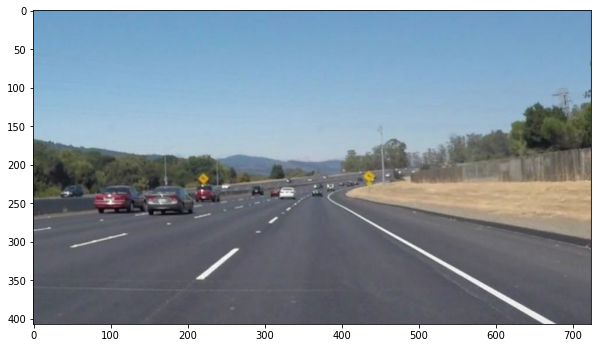

In [9]:
img = mpimg.imread('Car_line_detection.jpeg')

plt.figure(figsize=(10,8))
print('This image is: ', type(img), 'with dimensions: ', img.shape)
plt.imshow(img)
plt.show()

In [16]:
def grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
  return cv2.GaussianBlur(img, (kernel_size, kernel_size),0)

def canny(img, low_threshold, high_threshold):
  return cv2.Canny(img, low_threshold, high_threshold)

#### 차선을 완전히 포함하는 관심 영역 표기
region_of_interest_vertices = [(0,height),
                               (width/2, height/2),
                               (width, height)]

In [26]:
height = 407
width = 724

In [23]:
# 이미지 자르기 수행하는 함수
def region_of_interest(img, vertices) :
  # 이미지 높이/ 너비와 일치하는 빈 행렬을 정의한다.
  mask = np.zeros_like(img)

  # 이미지의 색상 채널 수를 검색한다.
  channel_count = img.shape[2]

  # 동일한 색상 채널 수로 일치 색상을 만든다.
  match_mask_color = (255,) * channel_count

  # 다각형 내부 채우기
  cv2.fillPoly(mask, vertices, match_mask_color)

  # 마스크 픽셀이 일치하는 이미지만 변환
  masked_image = cv2.bitwise_and(img, mask)
  return masked_image

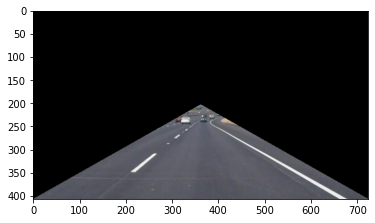

In [27]:
region_of_interest_vertices = [(0, height),
                               (width/2, height/2),
                               (width, height),]

image = mpimg.imread('Car_line_detection.jpeg')

cropped_image = region_of_interest(image, np.array([region_of_interest_vertices], np.int32))

plt.figure()
plt.imshow(cropped_image)

plt.show()

#### 잘린 이미지에서 가장자리 감지
<b>차 선을 둘러싼 데이터들에 주의를 기울이면 도로와 차선의 색상값이 매우 빠르게 변경되는 이미지 영역임을 알 수 있다.</b><br>
따라서 차 선을 감지하는 것은 픽셀이 모든 이웃과 색상이 일치하지 않는 영역을 감지하는 것을 의미힌다.

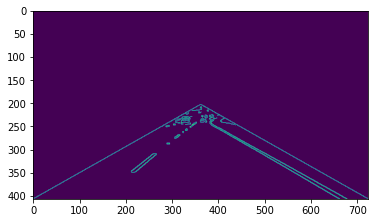

In [32]:
# gray scale로 변환
gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)

# Canny Edge Detection
cannyed_image = cv2.Canny(gray_image, 100, 200)

plt.figure()
plt.imshow(cannyed_image)

plt.show()

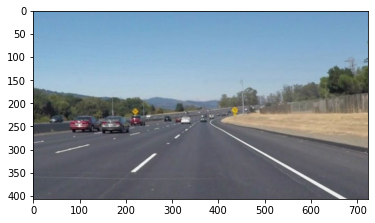

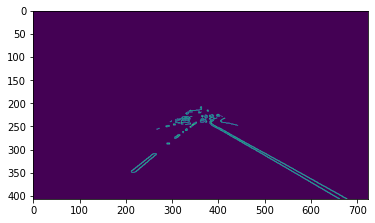

In [43]:
# 이미지 자르기 수행하는 함수
def region_of_interest(img, vertices) :
  # 이미지 높이/ 너비와 일치하는 빈 행렬을 정의한다.
  mask = np.zeros_like(img)

  # grayscale로 변경되었다.
  match_mask_color = 255

  # 다각형 내부 채우기
  cv2.fillPoly(mask, vertices, match_mask_color)

  # 마스크 픽셀이 일치하는 이미지만 변환
  masked_image = cv2.bitwise_and(img, mask)
  return masked_image

region_of_interest_vertices = [(0, height),
                               (width/2, height/2),
                               (width, height),]

image = mpimg.imread('Car_line_detection.jpeg')

plt.figure()
plt.imshow(image)
plt.show()

# gray scale로 변환
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Canny Edge Detection
cannyed_image = cv2.Canny(gray_image, 100, 200)

# 자르기 작업을 끝으로 이동
cropped_image = region_of_interest(cannyed_image, np.array([region_of_interest_vertices], np.int32))

plt.figure()
plt.imshow(cropped_image)
plt.show()


### Hough 변환을 사용하여 선 감지

In [45]:
image = mpimg.imread('Car_line_detection.jpeg')

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cannyed_image = cv2.Canny(gray_image, 100, 200)
cropped_image = region_of_interest(cannyed_image, np.array([region_of_interest_vertices], np.int32))

lines = cv2.HoughLinesP(cropped_image, rho=6, 
                        theta = np.pi/60, 
                        threshold = 160, 
                        lines = np.array([]), 
                        minLineLength = 40,
                        maxLineGap = 25)

print(lines)

[[[369 236 661 405]]

 [[363 237 504 309]]

 [[623 375 678 406]]

 [[250 323 367 228]]

 [[362 210 411 242]]

 [[361 210 410 242]]

 [[362 236 478 295]]

 [[544 331 644 388]]

 [[295 288 373 225]]

 [[338 216 437 273]]

 [[219 349 266 311]]

 [[289 288 374 227]]]


### 감지 된 Hough Lines을 Overlay로 렌더링
- 라인 감지 마지막으로 할 일은 감지 된 라인을 이미지 자체에 다시 렌더링하여 감지되는 장면의 실제 특징을 파악하는 것이다.

In [60]:
def draw_lines(img, lines, color = [255,0,0], thickness=3) : 
  # 그릴 선이 없으면 종료
  if lines is None:
    return

  # 원본 이미지 복사
  img = np.copy(img)

  # 원본 크기와 일치하는 빈 이미지를 만든다.
  line_img = np.zeros(
      (
          img.shape[0],
          img.shape[1],
          3
      ), 
      dtype=np.uint8
  )

  # 모든 선을 반복하고 빈 이미지에 그린다.
  for line in lines:
    for x1, y1, x2, y2 in line:
      cv2.line(line_img, (x1,y1), (x2,y2), color, thickness)

  # 원본에 선과 이미지를 병합한다.
  img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)

  # 수정된 이미지를 반환
  return img

#### HoughLinesP(image, rho, theta, threshold, ...)
#### Parameters:
- image: 8bit, single-channel binary image, canny edge를 선 적용
- rho : r값의 범위(0~1 실수)
- theta : theta의 범위(0~180 정수)
- threshold : 만나는 점의 기준, 숫자가 작으면 많은 선이 검출되지만 정확도가 떨어지고, 숫자가 크면 정확도가 올라감

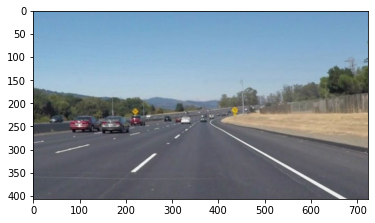

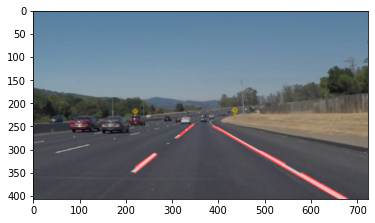

In [102]:
image = mpimg.imread('Car_line_detection.jpeg')

plt.figure()
plt.imshow(image)
plt.show()

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cannyed_image = cv2.Canny(gray_image, 100, 200)
cropped_image = region_of_interest(cannyed_image, np.array([region_of_interest_vertices], np.int32))

# HoughLinesP 함수 parameters 공부하기
lines = cv2.HoughLinesP(cropped_image, 
                        rho = 6, 
                        theta = np.pi/60, 
                        threshold = 160, 
                        lines = np.array([]), 
                        minLineLength = 30,
                        maxLineGap = 7)

line_image = draw_lines(image, lines)

plt.figure()
plt.imshow(line_image)
plt.show()